In [22]:
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from helper import *
from sklearn.model_selection import GridSearchCV

# Supress all warnings
import warnings
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
from matplotlib.patches import Patch
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression

In [23]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"
xls = pd.ExcelFile(path)

lipidomics = pd.read_excel(xls, "Lipidomics")
metabolomics = pd.read_excel(xls, "Pareto Metabolomics")
proteomics = pd.read_excel(xls, "Pareto Proteomics")

# Load the binary dataset
X_train, X_test, Y_train, y_test = concatenate_data(
    lipidomics, metabolomics, proteomics, num_classes=2)

Training set shape:  (58, 1118)
Testing set shape:  (38, 1118)


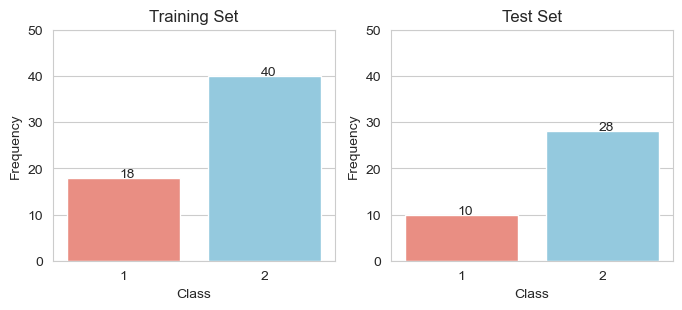

In [24]:
# Create a plot of the distribution of the classes in the training set
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
colors = ['salmon', 'skyblue']

Y_train_count, y_test_count = Y_train.value_counts(), y_test.value_counts()
y_lim = max(Y_train_count.max(), y_test_count.max()) + 10

# Add the count of each class on top of the bars
sns.barplot(x=Y_train_count.index, y=Y_train_count.values, ax=axs[0], palette=colors)
for p, label in zip(axs[0].patches, Y_train_count.values[::-1]):
    axs[0].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))
axs[0].set_title("Training Set")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")
axs[0].set_ylim(0, y_lim)

sns.barplot(x=y_test_count.index, y=y_test_count.values, ax=axs[1], palette=colors)
for p, label in zip(axs[1].patches, y_test_count.values[::-1]):
    axs[1].annotate(label, (p.get_x()+0.375, p.get_height()+0.15))

axs[1].set_title("Test Set")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")
axs[1].set_ylim(0, y_lim)
plt.show()


Add mapping of the classes

In [25]:
class_mapping = {1 : 0, 2 : 1}
# Mapping the classes
Y_train = Y_train.map(class_mapping)
y_test = y_test.map(class_mapping)
print(np.unique(Y_train))
print(np.unique(y_test))

[0 1]
[0 1]


# Plotting Functions

In [26]:
def plot_feature_importance(model, features, absolute=True, n=10, omics_labels=None):
    """
    https://forecastegy.com/posts/feature-importance-in-logistic-regression/
    :param model: Fitted model
    :param features: List of feature names (column names)
    :param absolute: Whether to take the absolute value of the coefficients
    :param n: Number of features to plot
    :param omics_labels: List of labels for the omics data 
    If the value is not absolute, we can see the direction of the effect of the feature on the target variable
    """
    coefficients = model.coef_[0]
    if absolute:
        coefficients = np.abs(coefficients)
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': coefficients})
    if omics_labels is not None:
        feature_importance['Omics'] = omics_labels
    # Sort the features based on the absolute value of the coefficient
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    
    # Select the top n features
    feature_importance = feature_importance[-n:]
    
    # Color the bars based on the coefficient sign
    plt.figure(figsize=(12, 8))
    if not omics_labels:
        plt.barh(
            feature_importance['Feature'], feature_importance['Importance']
        )
    else:
        values = np.unique(omics_labels)
        color_mapping = dict(zip(values, sns.color_palette('husl', len(values))))
        # Fill with gray if the omics data is not provided
        feature_importance['Color'] = (
            feature_importance['Omics'].map(color_mapping).fillna('gray'))
        plt.barh(
            feature_importance['Feature'], feature_importance['Importance'],
            color=feature_importance['Color']
        )
        # Add a legend for the omics data
        patches = [
            plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in color_mapping]
        plt.legend(
            patches, color_mapping.keys(), 
            loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.,
            title='Omics Type', title_fontsize='large', fontsize='large'
        )
        
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Logistic Regression Model)', fontsize=16)
    plt.show()

In [27]:
def standardize(X):
    """
    Standardize the data using the StandardScaler
    This is crucial for regularized models
    (otherwise features with larger scales dominate the regularization)
    :param X: Data
    """
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Logistic Regression

In [28]:
# Standardize the data
X_train = standardize(X_train)
X_test = standardize(X_test)


# Hyperparameter Tuning

In [29]:
hyperparams = {
    'C': [100, 10, 5, 1.0, 0.1, 0.01], # Regularization parameter
}

# Fit the model using grid search to find the best combination of hyperparameters
grid_search = GridSearchCV(
    estimator=LogisticRegression(
        max_iter=1000,
        multi_class='ovr', # Binary classification
        class_weight='balanced',
        penalty='l1', # Lasso Regularization
        solver='saga',
    ),
    param_grid=hyperparams,
    scoring='recall',
    cv=10,
    n_jobs=-1
).fit(X_train, Y_train)

{'C': 1.0}

Accuracy of the model:  0.7631578947368421
Recall of the model: 0.7632
Precision of the model: 0.7697
F1 score of the model: 0.7511


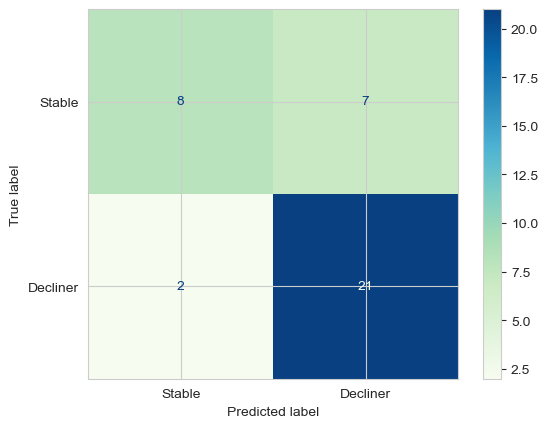

In [30]:
# Print the best hyperparameters
print(grid_search.best_params_)
evaluate_model(y_test, grid_search.predict(X_test))
best_model = grid_search.best_estimator_

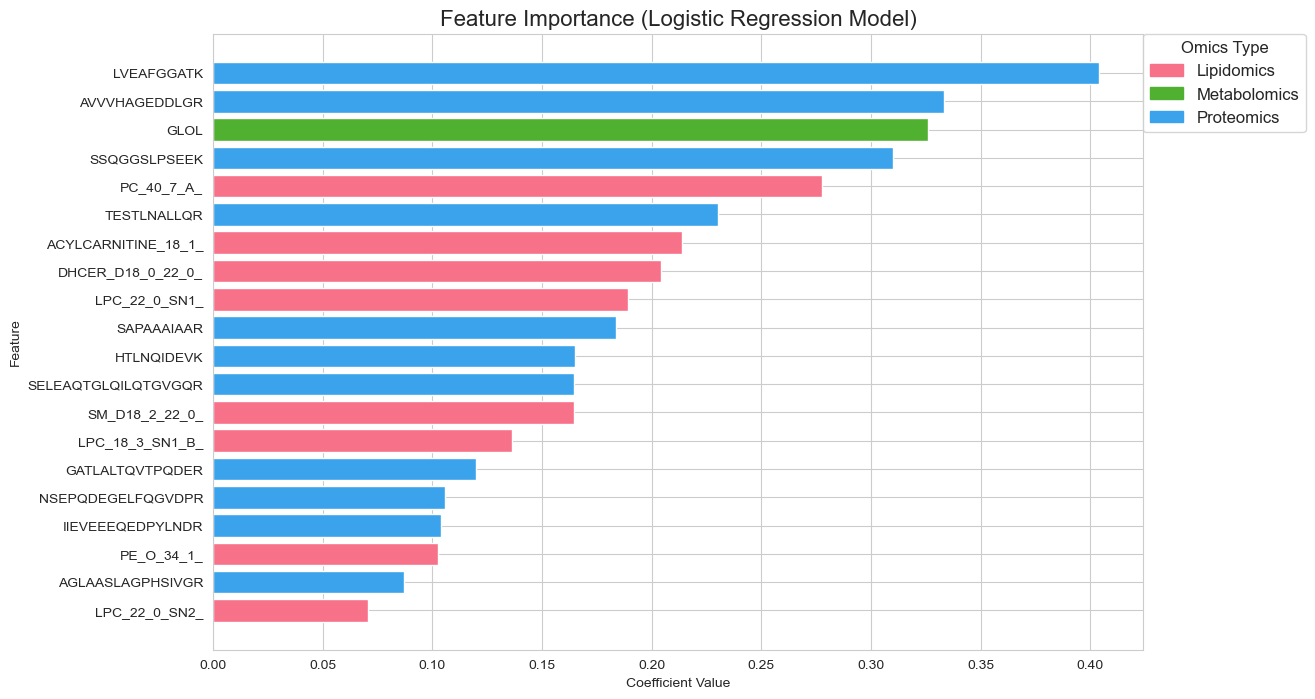

In [31]:
# Plot feature importance

# Remove the target variable
to_remove = ['ThreeClass', 'TwoClass', 'RID']
lipidomics_ = lipidomics.drop(columns=to_remove)
metabolomics_ = metabolomics.drop(columns=to_remove, )
proteomics_ = proteomics.drop(columns=to_remove)

variables = (lipidomics_.columns.tolist() 
             + metabolomics_.columns.tolist() 
             + proteomics_.columns.tolist())
omics_labels = []
for i in range(len(lipidomics_.columns)):
    omics_labels.append('Lipidomics')
for i in range(len(metabolomics_.columns)):
    omics_labels.append('Metabolomics')
for i in range(len(proteomics_.columns)):
    omics_labels.append('Proteomics')
plot_feature_importance(
     best_model, variables, absolute=False, n=20, omics_labels=omics_labels
)

## Feature Selection
Based on the coefficients of the model, we can select the most important features and remove the ones with 0 coefficients.

In [32]:
# Get the features with 0 coefficients
coefficients = best_model.coef_[0]
zero_features = np.where(coefficients == 0)[0]

print(f'Number of features with 0 coefficients: {len(zero_features)} out of {len(variables)}')

Number of features with 0 coefficients: 1035 out of 1111


In [33]:
non_zero_features = np.where(coefficients != 0)[0]
non_zero_features_names = np.array(variables)[non_zero_features]
features_data = []
for feature, coef in zip(non_zero_features_names, coefficients[non_zero_features]):
    data_type = 'Lipidomics' if feature in lipidomics_.columns else (
        'Metabolomics' if feature in metabolomics_.columns else 'Proteomics')
    print(f'{feature} ({data_type}): {coef}')
    features_data.append({'Feature': feature, 'Coefficient': coef, 'Type': data_type})
features_df = pd.DataFrame(features_data)

ACYLCARNITINE_18_1_ (Lipidomics): 0.21369102965880987
CE_15_0_ (Lipidomics): -0.007791954214625741
CE_24_6_ (Lipidomics): -0.22545816366684687
CER_D18_2_18_0_ (Lipidomics): 0.024229923790371977
CER_D18_2_20_0_ (Lipidomics): 0.03324435250121346
CER_D19_1_18_0_ (Lipidomics): -0.100562013916257
CER_D19_1_26_0_ (Lipidomics): -0.16086621170172113
DHCER_D18_0_20_0_ (Lipidomics): 0.005971015999498188
DHCER_D18_0_22_0_ (Lipidomics): 0.2043116613717863
GM3_D18_1_18_0_ (Lipidomics): -0.09904798638632009
GM3_D18_1_22_0_ (Lipidomics): -0.032680642483227905
GM3_D18_1_24_1_ (Lipidomics): -0.4882433599639066
HEXCER_D18_1_24_1_ (Lipidomics): -0.13282322562164267
LPC_18_3_SN1_B_ (Lipidomics): 0.13634290195229826
LPC_20_0_SN1_ (Lipidomics): 0.011996379618592052
LPC_20_0_SN2_ (Lipidomics): 0.03406393924101291
LPC_22_0_SN1_ (Lipidomics): 0.18943996144667874
LPC_22_0_SN2_ (Lipidomics): 0.07052673571319686
LPC_O_24_2_ (Lipidomics): -0.027089123147978282
LPI_18_2_SN2_ (Lipidomics): -0.008767765241214583
PC_1

In [34]:
# Save the feature names in a text file
path = 'C:/Users/mjgoj/PycharmProjects/ThesisFinal/insignificant/selected_features_logistic_regression.txt'
with open(path, 'w') as f:
    for feature in non_zero_features_names:
        f.write(f'{feature}\n')

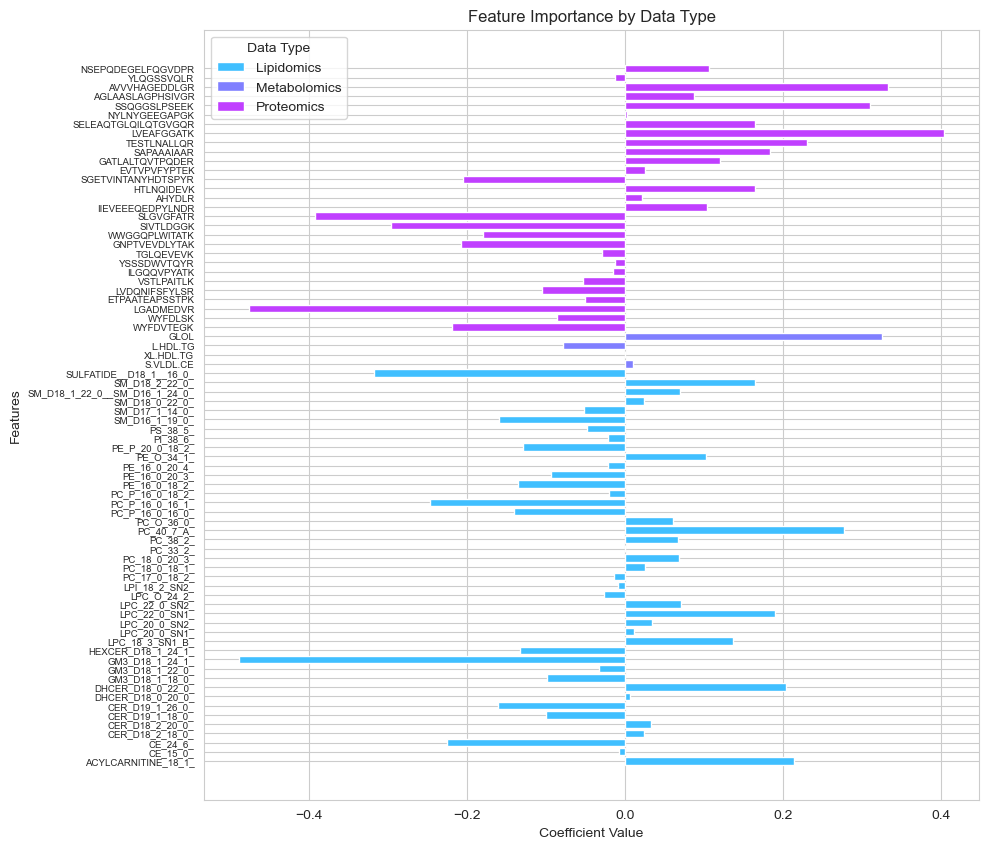

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
# Color mapping for each data type
palette = sns.color_palette('cool', 3)
colors = {'Lipidomics': palette[0], 'Metabolomics': palette[1], 'Proteomics': palette[2]}

# Create a bar plot
features_df['Color'] = features_df['Type'].map(colors)
ax.barh(features_df['Feature'], features_df['Coefficient'], color=features_df['Color'])

# Add legend
legend_elements = [Patch(facecolor=colors[type], label=type) for type in colors]
ax.legend(handles=legend_elements, title='Data Type')

# Labels and title
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance by Data Type')
# Change the size of the ticks
plt.yticks(fontsize=7)

plt.show()

# SHAP (SHapley Additive exPlanations)

Quantifies the impact of each feature on the model's output

In [36]:
explainer = shap.Explainer(
    grid_search.best_estimator_, X_train, feature_names=variables
)
# Compute SHAP values for each prediction made on the test data 
shap_values = explainer(X_test)

### SHAP Summary Plot

Shows SHAP values for all the features from the dataset, ordered by the sum of SHAP value magnitudes over all samples. The feature at the top has the highest overall impact on model output.

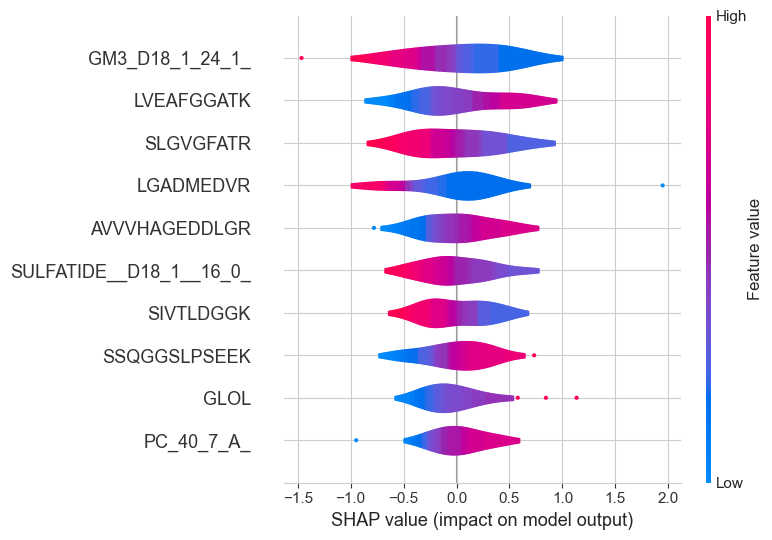

In [37]:
shap.summary_plot(shap_values, X_test, plot_type='violin', max_display=10)

# LIME (Local Interpretable Model-agnostic Explanations)

In [38]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, mode='classification', feature_names=variables
)

In [39]:
def LIME_explain_sample(sample_idx):
    true_class = y_test.iloc[sample_idx]
    print(f'True Class: {true_class}')
    
    sample = X_test[sample_idx]
    explanation = explainer.explain_instance(
        sample, grid_search.predict_proba, num_features=10, top_labels=1
    )
    explanation.show_in_notebook()
    
    explanation.as_pyplot_figure(label=0)

In [40]:
LIME_explain_sample(2)

True Class: 1


KeyError: 0